# 2層のニューラルネットワーク

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

### シグモイド関数（活性化関数）
$ h(x) = \frac{1}{1+exp(-x)} $

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

### ソフトマックス関数（出力層：分類問題）
$ y_k = \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)} $

In [32]:
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)  # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

### 交差エントロピー誤差（損失関数）
$ E = -\sum_{k}^{n}t_k log(y_k) $

In [33]:
def cross_entropy_error(y, t):
    batch_size = y.shape[0]
    t = t.argmax(axis=1)  # one-hot -> index 形式に変換
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

### シグモイド関数の勾配
$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} y(1-y) $

In [34]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

### MNIST データセット

In [35]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print("x_train.shape [N, H * W]:", x_train.shape)
print("t_train.shape:", t_train.shape, t_train.dtype)

x_train.shape [N, H * W]: (60000, 784)
t_train.shape: (60000, 10) float64


#### 【オプション】入力データの確認

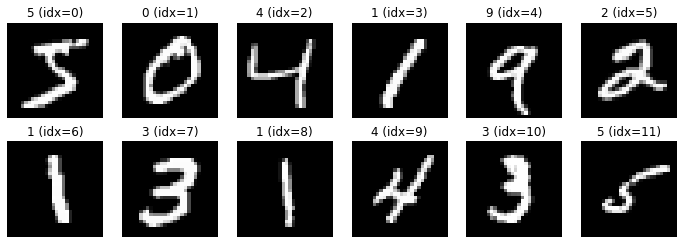

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [36]:
# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 784 -> 28x28 に変換
    plt.imshow(img, cmap='gray')
plt.show()
print(t_train[:rows * cols])

### ニューラルネットワークの定義

In [37]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

### ニューラルネットワークのインスタンス化

In [38]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
print(network)

### パラメータの定義

In [39]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### ミニバッチの学習

In [40]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

train_size = x_train.shape[0]  # 訓練データの数
iter_per_epoch = max(int(train_size / batch_size), 1)  # エポック毎の繰り返しの回数
iters_num = iter_per_epoch * epoch_num  # 全体の繰り返しの回数

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % iter_per_epoch == 0:
        epoch_count = int((i + 1) / iter_per_epoch)
        #print(f'epoch({epoch_count}) loss = {train_loss_list[-1]}')
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'epoch({epoch_count}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) accuracy(train, test) = (0.79205, 0.7966)
epoch(2) accuracy(train, test) = (0.8767333333333334, 0.8813)
epoch(3) accuracy(train, test) = (0.8984333333333333, 0.9019)
epoch(4) accuracy(train, test) = (0.9072333333333333, 0.9107)
epoch(5) accuracy(train, test) = (0.9141, 0.9163)
epoch(6) accuracy(train, test) = (0.9188666666666667, 0.9211)
epoch(7) accuracy(train, test) = (0.9224166666666667, 0.9238)
epoch(8) accuracy(train, test) = (0.9266833333333333, 0.9279)
epoch(9) accuracy(train, test) = (0.9296166666666666, 0.9316)
epoch(10) accuracy(train, test) = (0.9327333333333333, 0.9321)
epoch(11) accuracy(train, test) = (0.9351166666666667, 0.9355)
epoch(12) accuracy(train, test) = (0.9370333333333334, 0.9362)
epoch(13) accuracy(train, test) = (0.9394666666666667, 0.9398)
epoch(14) accuracy(train, test) = (0.9413333333333334, 0.941)
epoch(15) accuracy(train, test) = (0.9433666666666667, 0.9427)
epoch(16) accuracy(train, test) = (0.9451, 0.9436)
epoch(17) accuracy(train, test) = (0.

### 損失関数の推移

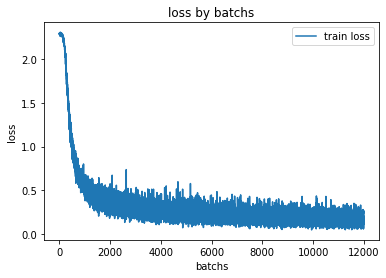

In [41]:
# グラフの描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

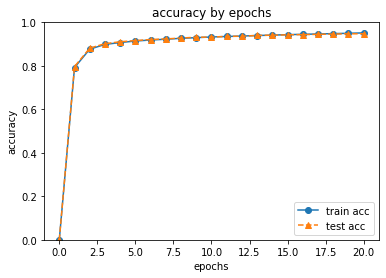

In [42]:
# グラフの描画
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [43]:
# テストの実行
test_predict = network.predict(x_test)
print(test_predict.shape)
for index in range(3):
    print(f'index = {index}')
    print(test_predict[index])
    print(t_test[index])

(10000, 10)
index = 0
[1.00119859e-04 4.14446634e-06 1.27767578e-03 6.09554849e-03
 4.88331501e-06 3.00516985e-04 1.46357875e-08 9.91692528e-01
 3.40016981e-05 4.90567226e-04]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
index = 1
[5.49948759e-03 1.13796548e-03 9.68232307e-01 1.35687157e-02
 1.55549033e-07 1.37800359e-03 8.83412026e-03 1.44617687e-07
 1.34878620e-03 3.14337299e-07]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index = 2
[7.74395442e-07 9.88240616e-01 4.75718201e-03 1.43353860e-03
 5.20971025e-05 9.09483555e-04 6.71213552e-04 2.98120456e-03
 8.94816985e-04 5.90731330e-05]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


#### 【オプション】エラー結果の確認

error rate = 5.25[%] (num = 525/10000)


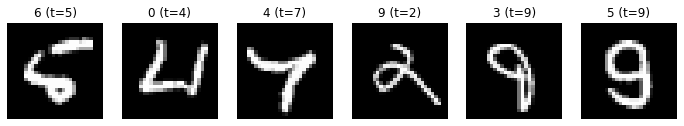

[[5.74425991e-03 1.00297506e-05 2.68273091e-02 3.98258895e-06
  9.80525213e-03 1.42422426e-02 9.38631470e-01 3.73327397e-06
  4.49660120e-03 2.35119028e-04]
 [3.27717875e-01 6.47235469e-07 5.06583243e-02 6.35069857e-06
  2.90065075e-01 3.57001410e-02 2.93465886e-01 1.30212887e-04
  1.85593055e-03 3.99557943e-04]
 [7.15398028e-06 4.22203374e-05 4.06785328e-06 2.07917016e-04
  6.65828623e-01 8.20562450e-04 5.88295944e-05 2.36235534e-01
  3.31274921e-03 9.34823424e-02]
 [1.21815714e-04 3.29238194e-03 8.23764895e-02 9.07074959e-02
  3.11453218e-01 7.38251508e-03 1.11292681e-02 1.01163290e-02
  4.55822054e-02 4.37838281e-01]
 [5.32483614e-06 1.56100362e-03 8.67858887e-03 4.80321303e-01
  1.88167085e-01 4.70898146e-03 2.10535986e-04 4.86806810e-02
  3.06263168e-02 2.37040180e-01]
 [1.38542425e-02 1.81038227e-04 1.96528437e-02 2.08947208e-01
  6.00705466e-03 3.03896754e-01 2.63267502e-04 6.39998590e-03
  2.54428322e-01 1.86369283e-01]]


In [44]:
# エラー結果の要素を抽出
index_error = np.argmax(test_predict, axis=1) != np.argmax(t_test, axis=1)
error_list = np.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]', \
      f'(num = {len(error_list)}/{len(test_predict)})')

offset = 0
# 画像を表示
figure = plt.figure(figsize=(12, 2))
rows, cols = 1, 6
for i in range(rows * cols):
    index = error_list[offset + i]
    img, label_t, label_y = x_test[index], t_test[index].argmax(), test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    img = img.reshape(28, 28)  # 784 -> 28x28 に変換
    plt.imshow(img, cmap='gray')
plt.show()
print(test_predict[error_list[offset:offset + rows * cols]])